# Import Appropriate Modules

In [2]:
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import xgboost as xgb
import sklearn
import random
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import talib as ta
import lightgbm as lgb
from hyperopt import fmin, hp, partial, tpe, Trials

#silence warnings output...
import warnings
warnings.filterwarnings("ignore")

#following for the ML part...setting a seed meant that multiple executions will yield the same result.
random_state = 42
random.seed(random_state)

# Paths and Load CSV (Modify Path Here)

In [ ]:
historical_data_path = '''second_round_datasets'''
MARKET_DATA_PATH = f'{historical_data_path}/second_round_train_market_data.csv'
FUNDAMENTAL_DATA_PATH = f'{historical_data_path}/second_round_train_fundamental_data.csv'
RETURN_DATA_PATH = f'{historical_data_path}/second_round_train_return_data.csv'

df_market = pd.read_csv(MARKET_DATA_PATH)
df_fund = pd.read_csv(FUNDAMENTAL_DATA_PATH)
df_return = pd.read_csv(RETURN_DATA_PATH)
print(f"Columns of df_market are: {list(df_market.columns)}")
print(f"Columns of df_fund are: {list(df_fund.columns)}")
print(f"Columns of df_return are: {list(df_return.columns)}")

In [ ]:
#To Create columns containing data column of "date_time"
def interval_split(dt):
    #for date_time column of "sXXdXXpXX"
    f2, f3 = dt.find("d"), dt.find("p")
    return [int(dt[1:f2]), int(dt[f2+1:f3]), int(dt[f3+1:])]
def date_split(dt):
    #for date_time column of "sXXdXX"
    f2 = dt.find("d")
    return [int(dt[1:f2]), int(dt[f2+1:])]
def add_interval(df):
    df_interval_data = np.vstack(df.date_time.apply(lambda x: interval_split(x)))
    df[["asset", "day", "interval"]] = df_interval_data
    return df
def add_date(df):
    df_date_data = np.vstack(df.date_time.apply(lambda x: date_split(x)))
    df[["asset", "day"]] = df_date_data
    return df
print("Ran")

# Features Library

In [ ]:
def add_period(df):
    #no intervals
    df_period = df[['asset', 'day']]
    for i in range(2, 15):
        df_period[f"period{i}"] = df["day"] // i
    return df_period
def add_remainder(df):
    #no intervals
    df_remainder = df[['asset', 'day']]
    for i in range(2, 15):
        df_remainder[f"remainder{i}"] = df["day"] % i
    return df_remainder

def ctc_returns(df_market_a):
    #no intervals
    df_ctc = df_market_a[['asset', 'day']].reset_index(drop=True)
    for days in [1, 5, 10, 20]:
        df_ctc[f"ctc{days}"] = df_market_a['close'].pct_change(days).reset_index(drop=True)
    return df_ctc


def daily_volume_moving_ratio(df_market_a):
    #contains intervals
    #take df by asset type
    daily_volume_series = df_market_a.groupby(df_market_a['day'])['volume'].sum()
    df_movv = df_market_a[['asset', 'day']].drop_duplicates(subset=["asset", "day"], keep='last').reset_index(drop=True)
    df_movv["daily_volume_moving_ratio_5d"] = daily_volume_series / daily_volume_series.rolling(5).mean()
    df_movv["daily_volume_moving_ratio_10d"] = daily_volume_series / daily_volume_series.rolling(10).mean()
    df_movv["daily_volume_moving_ratio_20d"] = daily_volume_series / daily_volume_series.rolling(20).mean()
    return df_movv


#Talib Features **
def add_talib_features(df_market_a):
    #This function take reference to the "construct_talib_features" function and tailor to our dataframe settings
    #by creating asset, day, interval columns (prior), following code should be more understandable
    close_p = df_market_a[df_market_a['interval'] == 50]['close'].reset_index(drop=True)
    high_p = df_market_a.groupby(df_market_a['day'])['high'].max().reset_index(drop=True)
    low_p = df_market_a.groupby(df_market_a['day'])['low'].min().reset_index(drop=True)

    feature_df = df_market_a[['asset', 'day']].drop_duplicates(subset=["asset", "day"], keep='last').reset_index(drop=True)
    feature_df["SAR"] = ta.SAR(high_p, low_p, acceleration = 0, maximum = 0)
    feature_df["SAREXT"] = ta.SAREXT(high_p, low_p, startvalue = 0, offsetonreverse = 0, accelerationinitlong = 0, accelerationlong = 0, accelerationmaxlong = 0, accelerationinitshort = 0, accelerationshort = 0, accelerationmaxshort = 0)
    feature_df["RSI"] = ta.RSI(close_p, timeperiod = 14) - 50
    feature_df["HT_DCPERIOD"] = ta.HT_DCPERIOD(close_p)
    feature_df["HT_PHASOR_inphase"], feature_df["HT_PHASOR_quadrature"] = ta.HT_PHASOR(close_p)
    feature_df["HT_SINE_sine"], feature_df["HT_SINE_leadsine"] = ta.HT_SINE(close_p)
    return feature_df


In [6]:
#Features in Consideration
def merge_columns(market, fundamental, returns=pd.DataFrame([0])):
    market = add_interval(market)
    fundamental = add_date(fundamental)
    df = pd.merge(market, fundamental, left_on=["asset", "day"], right_on=["asset", "day"])
    if returns.any()[0]:    #check if returns is a non-empty dataframe
        returns = add_date(returns)
        df = pd.merge(df, returns, left_on=["asset", "day"], right_on=["asset", "day"])
    # Note: This Step Will Mean that Metrics regarding
    return df
    # df = df.drop_duplicates(subset=["asset", "day"], keep='last').reset_index(drop=True)

def add_features(df):
    #THIS will return columns with only one set of ['asset', 'day'] (no intervals)
    df_close_only = df.drop_duplicates(subset=["asset", "day"], keep='last').reset_index(drop=True)
    df_features = df_close_only[['asset', 'day']]     #a df that contains the new feature to reduce loading time in each function call.

    #features not using intervals data
    df_features = pd.merge(df_features, add_period(df_close_only), left_on=["asset", "day"], right_on=["asset", "day"])
    df_features = pd.merge(df_features, add_remainder(df_close_only), left_on=["asset", "day"], right_on=["asset", "day"])
    df_features = pd.merge(df_close_only, df_features, left_on=["asset", "day"], right_on=["asset", "day"])

    #ctc returns
    ctc_features = pd.concat([ctc_returns(df_close_only[df_close_only['asset'] == i]) for i in range(54)]).reset_index(drop=True)
    df_features = pd.merge(df_features, ctc_features, left_on=["asset", "day"], right_on=["asset", "day"])

    #moving volume
    movv_features = pd.concat([daily_volume_moving_ratio(df[df['asset'] == i]) for i in range(54)]).reset_index(drop=True)
    df_features = pd.merge(df_features, movv_features, left_on=["asset", "day"], right_on=["asset", "day"])

    #talib features: iterate over each asset together, then merge by ["asset", "day"]
    talib_features = pd.concat([add_talib_features(df[df['asset'] == i]) for i in range(54)]).reset_index(drop=True)
    df_features = pd.merge(df_features, talib_features, left_on=["asset", "day"], right_on=["asset", "day"])
    return df_features

In [7]:
df_temp = merge_columns(df_market, df_fund, df_return)
df = add_features(df_temp)
df

,date_time_x,open,close,high,low,volume,money,asset,day,interval,...,daily_volume_moving_ratio_10d,daily_volume_moving_ratio_20d,SAR,SAREXT,RSI,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine
0,s0d1p50,24.3731,24.3852,24.3852,24.3731,170476.0,4.157520e+06,0,1,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s1d1p50,16.1557,16.1314,16.2771,16.1071,70944.0,1.146780e+06,1,1,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s2d1p50,9.0307,9.0307,9.0307,9.0307,84204.0,7.603632e+05,2,1,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,s3d1p50,9.1521,9.1763,9.1763,9.1521,228997.0,2.099301e+06,3,1,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s4d1p50,5.0494,5.0615,5.0615,5.0494,114443.0,5.790603e+05,4,1,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91687,s49d1698p50,27.6139,27.5168,27.6139,27.5168,763444.0,2.100876e+07,49,1698,50,...,0.682980,0.454241,11.0699,11.0699,-10.992403,21.998470,-0.801573,0.356923,-0.959057,-0.477895
91688,s50d1698p50,28.8277,28.8642,28.8642,28.8277,129948.0,3.750945e+06,50,1698,50,...,0.640335,0.678836,7.3556,7.3556,-0.750675,25.147935,1.696683,-2.689594,0.969677,0.858474
91689,s51d1698p50,10.1110,10.0867,10.1110,10.0867,231000.0,2.330026e+06,51,1698,50,...,0.556928,0.466114,2.9010,2.9010,-14.200377,21.026962,0.032812,-0.105423,0.420903,0.939044
91690,s52d1698p50,70.9709,70.7645,70.9709,70.7645,133374.0,9.435887e+06,52,1698,50,...,0.615270,0.680688,8.1567,8.1567,8.323664,24.073693,3.718971,-1.475908,0.256981,-0.501647


# Some Insights on Graphs

Text(0, 0.5, 'RSI')

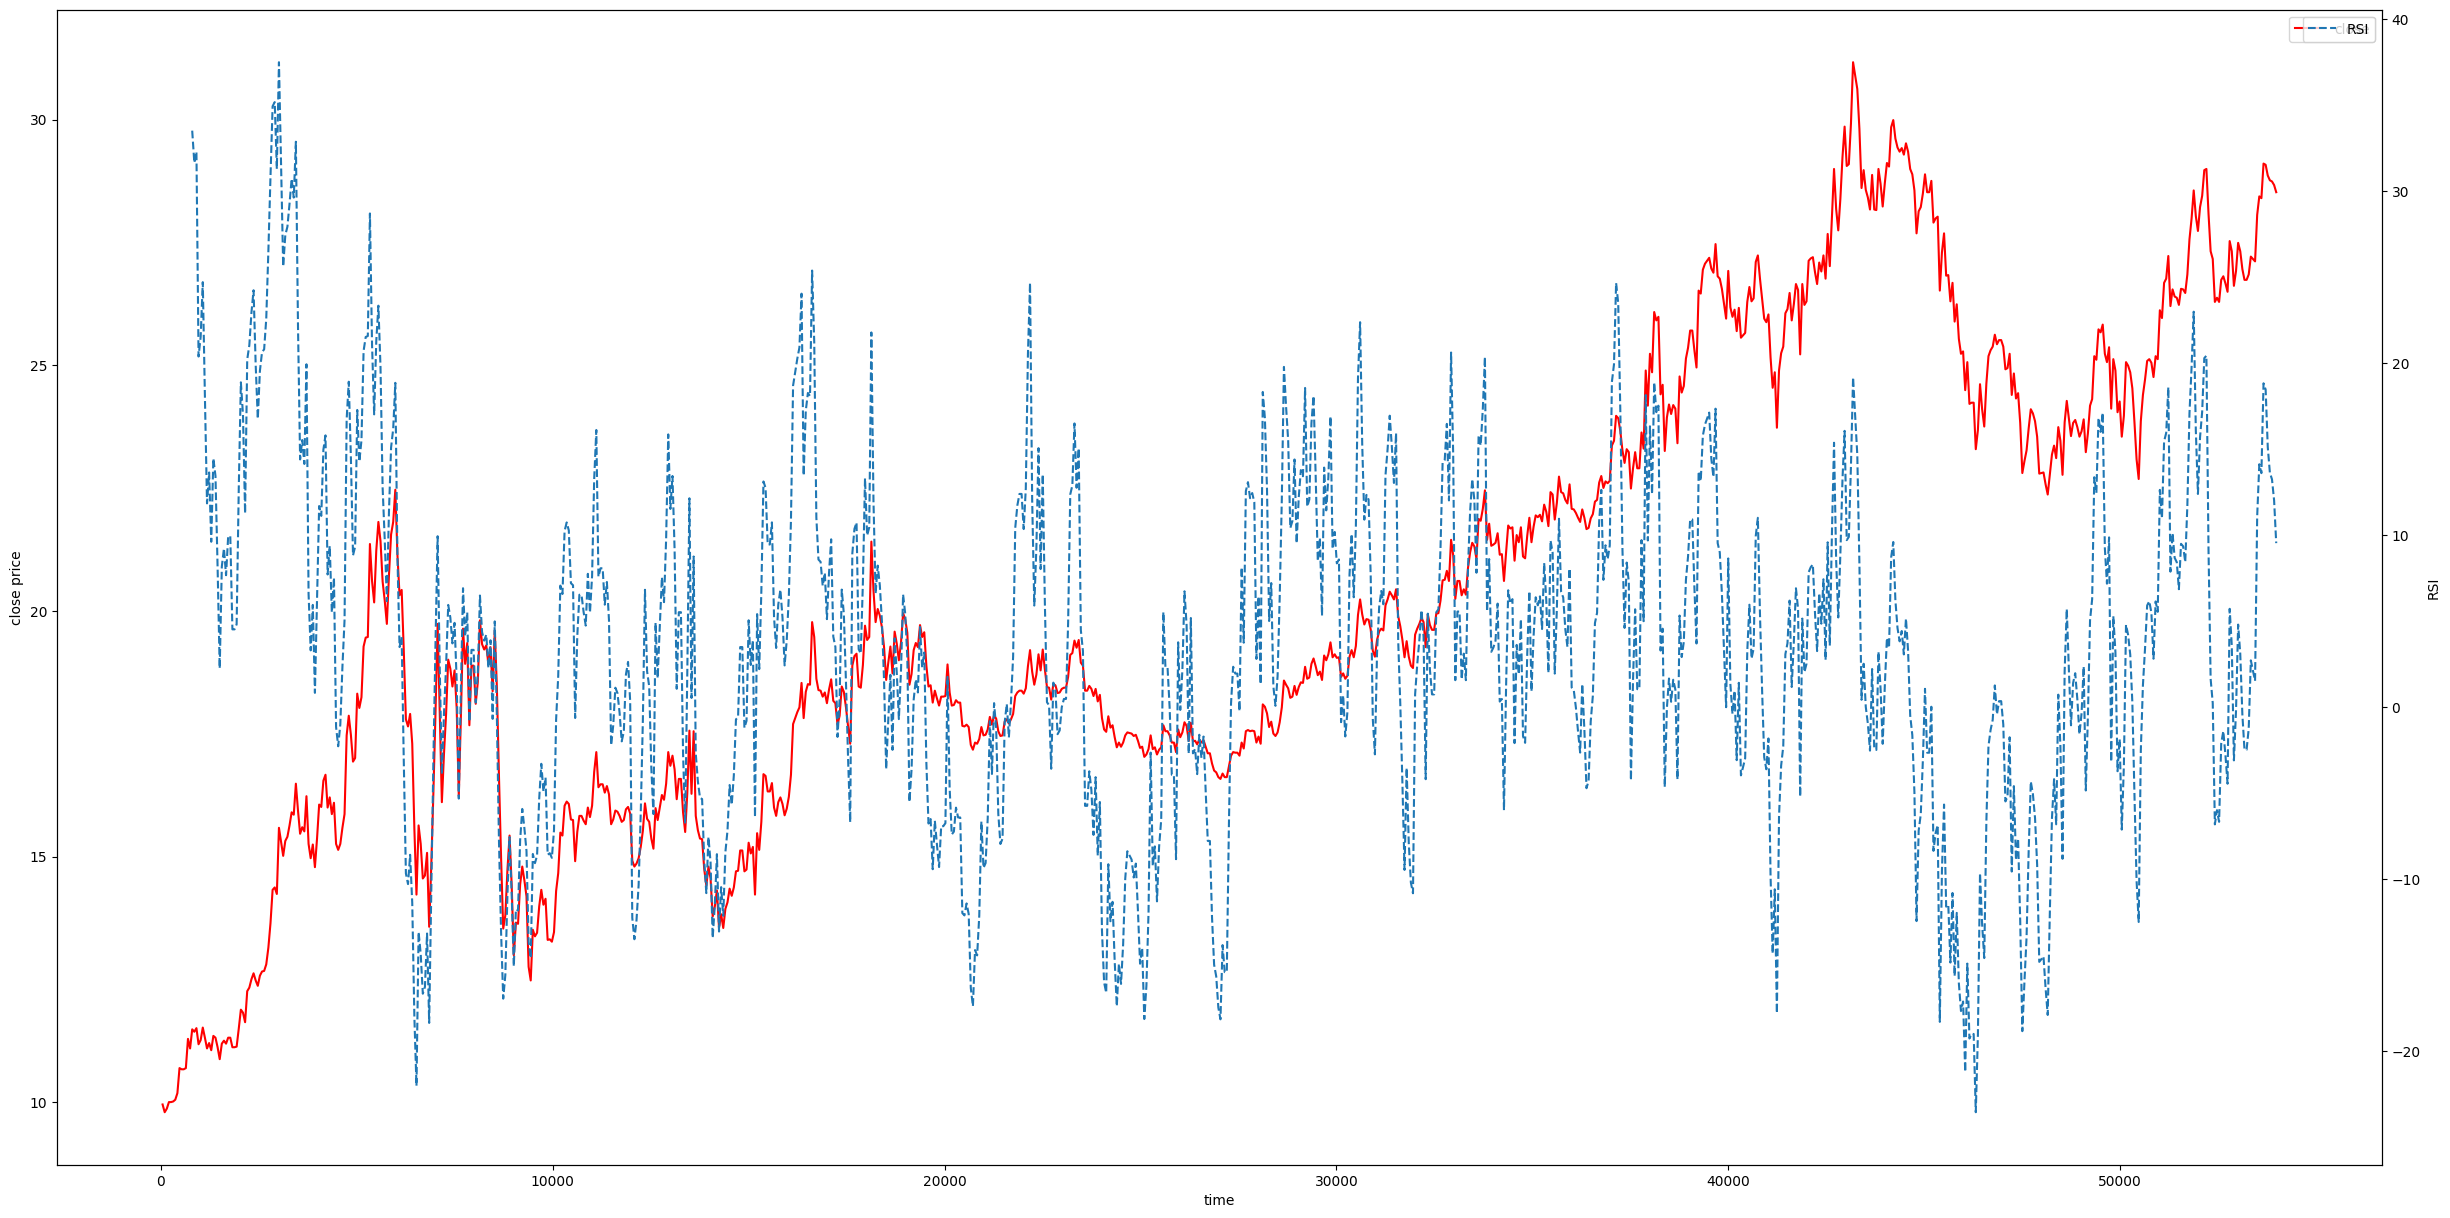

In [8]:
asset_to_check = 43
df_temp = df[(df['asset'] == asset_to_check) & (df['day'] <= 1000)][['close', 'RSI']]
ax = df_temp[['close']].plot(figsize=(30, 15), color='red')
ax.set_xlabel("time")
ax.set_ylabel("close price")
#ax2 is to construct a second y axis on the graph (ax object)
ax2 = ax.twinx()
df_temp[['RSI']].plot(ax=ax2, style="--")
ax2.set_ylabel("RSI")

# Putting it to the Model (Reusing Part1's XGBoost (replace with lightgbm later?))

In [9]:
def add_lag(df, target_map):
    for i in [700, 750, 800, 850, 900, 950]:   #needs to be larger than the 700 days in the future.
        df[f'lag{i}'] = (df.index - i*54).map(target_map)       #since each asset row is distanted at 54 rows (by 53)
    return df

In [10]:
global returns_avg
#f for features (build the features by adding lists)
f_base = ['turnoverRatio', 'transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']
f_period = [f"period{i}" for i in range(2, 15)]
f_remainder = [f"remainder{i}" for i in range(2, 15)]
f_remainder_trimmed = ['remainder7', 'remainder14']
f_ctc = ['ctc1', 'ctc5', 'ctc10', 'ctc20']
f_movv = ['daily_volume_moving_ratio_5d', 'daily_volume_moving_ratio_10d', 'daily_volume_moving_ratio_20d']
f_ta = ['SAR', 'SAREXT', 'RSI', 'HT_DCPERIOD', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_SINE_sine', 'HT_SINE_leadsine']
f_lag = [f"lag{i}" for i in [700, 750, 800, 850, 900, 950]]

features_build = f_base + f_remainder_trimmed + f_lag

TARGET = 'return'

In [11]:
def train_predict(df_train, df_test, asset_type, features):
    # major changes to previous one: previous we have set arbitary where to split train and test set (e.g. 7:3)
    # this version make uses tss to have multiple folds of train and test sets (*without information leakage)
    lag_adjuster = df_train.shape[0]

    df_train = df_train[df_train['asset'] == asset_type]
    df_test = df_test[df_test['asset'] == asset_type]

    train_map = df_train['return'].to_dict()
    df_train = add_lag(df_train, train_map)
    df_train['isFuture'] = False
    df_test['isFuture'] = True
    df_test.index += lag_adjuster
    train_and_test = pd.concat([df_train, df_test])
    tat_map = train_and_test['return'].to_dict()
    train_and_test = add_lag(train_and_test, tat_map)
    df_test = train_and_test[train_and_test['isFuture'] == True].copy()

    x_all = df_train[features]
    y_all = df_train[TARGET]

    params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 3,
    'learning_rate': 0.4,
    'metric': 'rmse',
    'n_estimators': 2000
    }

    reg = lgb.LGBMRegressor(**params) 
#     reg = xgb.XGBRegressor(n_estimators=2000,
#                     booster="gbtree",
#                     objective="reg:linear",
#                     max_depth=2,            #high value leads to overfitting
#                     learning_rate=0.4,
#                     min_child_weight=6,             #higher value prevent overfitting (1000:700 ratio makes it easy to overfit)
#                     subsample=1,
#                     )
    
    reg.fit(x_all, y_all,
            eval_set=[(x_all, y_all)],
            verbose=20)
    
    df_test['prediction'] = reg.predict(df_test[features])
    df_progress = df_test[['prediction']]
    #return df_progress
    avg_adjusted_prediction = df_progress['prediction'] - (df_progress['prediction'].mean() - returns_avg[asset_type])
    return avg_adjusted_prediction 

In [12]:
def train_predict_all():
    # df_all should contain 1700 days of data here.
    df_all = add_features(merge_columns(df_market, df_fund, df_return))
    #day_splitter is only for internal testing purpose, all 1700 days of data will be used to train the model.
    day_splitter = int(df_all['day'].max() * 0.7)
    print(day_splitter)
    df_train = df_all[df_all['day'] <= day_splitter]
    df_test = df_all[df_all['day'] > day_splitter]


    global returns_avg
    returns_avg = [df_train[df_train['asset'] == i]['return'].mean() for i in range(54)]

    df_res = train_predict(df_train, df_test, 0, features_build)
    for i in range(1, 54):
        df_res = pd.concat((df_res, train_predict(df_train, df_test, i, features_build)))

    df_copy = df_res.sort_index()
    df_copy = df_copy.reset_index()
    dt_col = df_fund['date_time']
    df_copy['date_time'] = dt_col
    df_copy = df_copy[['date_time', 'prediction']]
    df_copy.columns = ['date_time', 'return']
    return df_copy

df_res = train_predict_all()
df_res
        

NameError: name 'df_train_market' is not defined

# Future Hacking and Hyper Parameter Tuning 👎

In [ ]:
df_2day_return = df_market[df_market['interval'] == 50]
df_2day_return = df_2day_return.reset_index()
df_2day_return = df_2day_return[['date_time', 'close']]
close_map = df_2day_return['close'].to_dict()

df_2day_return['close_2day_later'] = (df_2day_return.index + 2*54).map(close_map)
df_2day_return['2day_return'] = (df_2day_return['close_2day_later'] - df_2day_return['close']) / df_2day_return['close']
df_2day_return = df_2day_return.fillna(0)
real_2day_returns = df_2day_return['2day_return']

df_2day_return2 = df_2day_return.copy()
df_2day_return2['close_2day_later'] = (df_2day_return2.index - 2*54).map(close_map)
df_2day_return2['2day_return'] = (df_2day_return2['close_2day_later'] - df_2day_return2['close']) / df_2day_return2['close']
df_2day_return2 = df_2day_return2.fillna(0)
real_2day_returns2 = df_2day_return2['2day_return']

real_2day_returns

In [ ]:
print(df_res['return'].corr(real_2day_returns)) #should be the correct one.
print(df_res['return'].corr(real_2day_returns2))

# Makeshift Analysis on the return of the investment

A very basic computation of the average return among the asset chosen on each day, without catering transaction fees or closing fees.

In [ ]:
df_test = add_date(df_res)
df_test

In [ ]:
for d in range(1001, 1002):
    return_list = df_test[df_test['day'] == d]['return']
    returns_based_decision = return_list.apply(lambda x: 1 if x > 0.02 else 0)
    # returns_based_decision = list(returns_based_decision)
    print(f"This is Day: {d}, Returns are:")
    returns_based_weighting = returns_based_decision / returns_based_decision.sum()
    print(returns_based_weighting)